In [1373]:
import tensorflow as tf
import numpy as np
import nevergrad as ng
import matplotlib.pyplot as plt
import matplotlib
import random
import PIL
from PIL import Image, ImageFont, ImageDraw

In [871]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [174]:
def U(a, b, c=None):
    if c is None:
        c = len(b)
    a = a + ([None] * (c - len(a)))
    return [ai if ai else b[i] for i, ai in enumerate(a)]

In [363]:
# plt.style.available

In [1291]:
def show(im=None, data=[], plot_func='imshow', style='fivethirtyeight', axis='off', figure={}, **kwargs):
    plt.close('all')
    plt.style.use(style)
    fig = plt.figure(**figure)
    ax = fig.add_subplot()
#     ax.imshow(im)
    if im is not None:
        data = [im]+data
    getattr(ax, plot_func)(*data, **kwargs)
    plt.axis(axis)
    return ax

<AxesSubplot:>

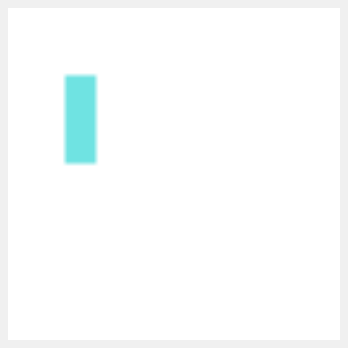

In [1292]:
def rectangle(dims=[None]*3):
    dims = U(dims, [64, 64, 3])
    bg = 255
    rect = np.full(dims, bg, dtype=int)
    size = 20
    x = random.randint(0, dims[0]-size)
    y = random.randint(0, dims[1]-size)
    w = random.randint(5, size)
    h = random.randint(5, size)
    rect[x:x+w, y:y+h] = np.random.randint(100, 230, [3], dtype=int)
    return rect

show(rectangle([64,64]), figure={'figsize':[5,5]})

<AxesSubplot:>

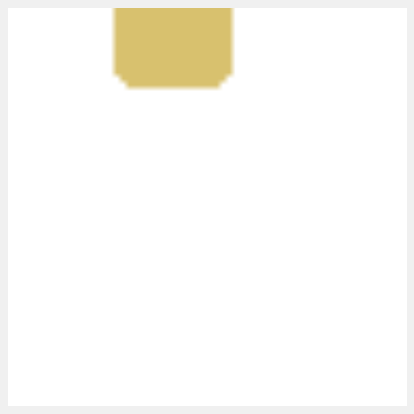

In [1792]:
def shape(dims=[], res=64):
    dims = U(dims, [res, res, 3])
    canvas = np.full(dims, 255, dtype=int)
    pos = np.random.randint([0, 0], canvas.shape[:2], [2])
    grid = np.stack(np.meshgrid(*[np.arange(0, dim, 1) for dim in canvas.shape[:2]]), axis=2)
    color = np.random.randint(100, 230, [3], dtype=int)
    canvas[np.linalg.norm(pos - grid, axis=2, ord=np.random.randint(1, 5)) < 10] = color
    meta = {
        'pos': pos,
        'color': color
    }
    return canvas, meta

show(shape()[0])

<AxesSubplot:>

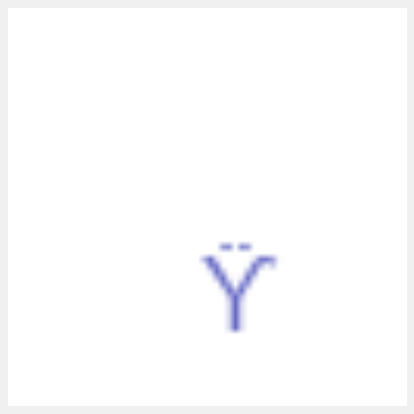

In [1698]:
def symbol(c=None, res=64, dims=[], font=None):
#     typehandler = {
#         'int'
#     }
    if c is None:
        cn = np.random.randint(0, 1000)
        c = chr(cn)
#         print(c,cn)
    dims = U(dims, [res, res, 3])
    canvas = np.full(dims, 255, dtype=int)
    fonts = ['arial', 'calibri', 'bahnschrift']
    max_size = min(dims[:2])//2
    size = np.random.randint(max_size//4, max_size)
    if not font:
        font = ImageFont.truetype(random.choice(fonts), size)
    color = np.random.randint(100, 230, [3], dtype=int)
    img = Image.fromarray(canvas.astype(np.uint8))
#     np.array(dims)//4
    pos = np.random.randint(0, np.array(dims)[:2]-size)
    ImageDraw.Draw(img).text(tuple(pos), c, tuple(color), font=font)
    meta = {
        'c': c
    }
    return np.array(img), meta

show(symbol()[0])

In [1489]:
chr(14)

'\x0e'

float64 (100, 128, 128, 3)


<AxesSubplot:>

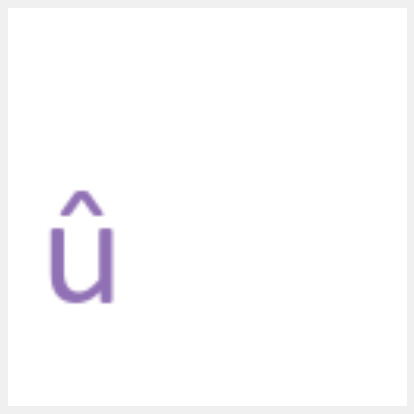

In [1786]:
def gen_data(F=symbol, N=100):
    return zip(*[F(res=128) for i in range(N)])
data, metadata = gen_data()
data = np.array(data)/255
print(data.dtype, data.shape)
show(data[0])
# todo: record creation parameters

In [1746]:
data.nbytes

39321600

In [1704]:
metadata[5]

{'c': ','}

In [1787]:
tf.keras.backend.clear_session()
def dense_layers(sizes, A):
    return [tf.keras.layers.Dense(s, activation=A) for s in sizes]
Layers = tf.keras.layers
activation = 'sigmoid'
stride = (1, 1)
batchnorm = {'center': 0.5}
resolution = 128
R = resolution
encoder_layers = [
    Layers.InputLayer(input_shape=(R, R, 3)),
    Layers.Lambda(lambda I: tf.image.resize(I, (R//2, R//2), method='bilinear')),
    
    Layers.Conv2D(8, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    
    Layers.Conv2D(16, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    
    Layers.Conv2D(32, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    Layers.MaxPooling2D((2, 2)),
    Layers.Conv2D(32, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
#     very helpful at getting past the 'averaging' local minimum (where we get a white or light gray image that essentially averages the training data)
    Layers.BatchNormalization(**batchnorm),
    Layers.MaxPooling2D((2, 2)),
    
    Layers.Conv2D(32, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.MaxPooling2D((2, 2)),
    
    Layers.Conv2D(64, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.MaxPooling2D((2, 2)),
    
#     tf.keras.preprocessing.image.smart_resize((20,20)),
#     tf.keras.preprocessing.image.apply_affine_transform()
#     tf.image
    Layers.Flatten(),
    *dense_layers([100, 50, 7], activation),
#     Layers.Dense(400, activation=activation),
#     Layers.Dense(200, activation=activation),
#     Layers.Dense(3, activation=activation),
]

decoder_layers = [
#     Layers.Dense(100, activation=activation),
    Layers.Dense(8**2*4, activation=activation),
    Layers.Reshape((8, 8, 4)),
    Layers.UpSampling2D((2, 2), interpolation='bilinear'),
#     Layers.Pooling ?
    
    Layers.Conv2DTranspose(32, 3, padding='same', activation='relu', dilation_rate=1, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.UpSampling2D((2, 2), interpolation='bilinear'),
    
    Layers.Conv2DTranspose(16, 3, padding='same', activation='relu', dilation_rate=1, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.UpSampling2D((2, 2), interpolation='bilinear'),
    
    Layers.Conv2DTranspose(8, 3, padding='same', activation='sigmoid', dilation_rate=1, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.UpSampling2D((2, 2), interpolation='bilinear'),
    
    Layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid', dilation_rate=1, data_format='channels_last'),
    Layers.BatchNormalization(**batchnorm),
    Layers.Conv2D(3, 3, strides=stride, padding='same', activation=activation, data_format='channels_last'),
    
#     Layers.Conv2DTranspose(3, 10, (2, 2), padding='same', activation='relu', dilation_rate=1, data_format='channels_last'),
#     Layers.Dense((20)**2*3),
#     clip layer?
]

model = tf.keras.models.Sequential(encoder_layers + decoder_layers)
encoder = tf.keras.models.Sequential(encoder_layers)
decoder = tf.keras.models.Sequential(decoder_layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MSE
#     'mse'
)
model.summary()

full_history = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

<AxesSubplot:>

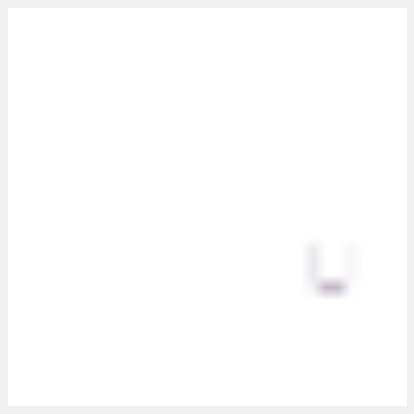

In [1754]:
show(Layers.Lambda(lambda I: tf.image.resize(I, (32, 32), method='bilinear', antialias=False))(data[2:3])[0])

<tensorflow.python.keras.layers.core.Lambda object at 0x0000028948CD1310> 0.9968377
--------------------
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028948CDB610> 0.4795176
--------------------
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000028948CDB9A0> 0.47927803
--------------------
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028948CE2EB0> 0.5233487
--------------------
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000028948CE2CA0> 0.5230872
--------------------
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028948CE27C0> 0.49767417
--------------------
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000028948CE2490> 0.5007875
--------------------
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028948CE2070> 0.5133756
--------------------
<tensorflow.python.keras.layers.normalization_v2.BatchNormalizati

<AxesSubplot:>

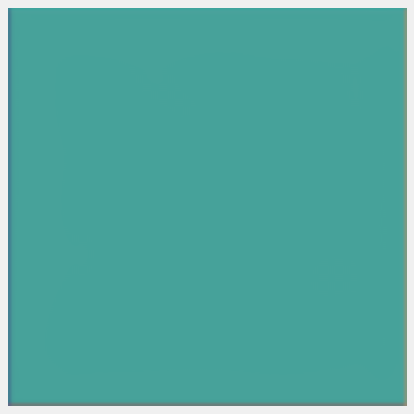

In [1755]:
p = data[5:6]
ims = []
for l in model.layers:
    p = l(p)
    print(l, p.numpy().mean())
    print('-'*20)
    if len(p.shape)>=3:
        ims.append(p[0])
show(ims[-1])

Epoch 1/10
4/4 - 0s - loss: 0.0012
Epoch 2/10
4/4 - 0s - loss: 0.0011
Epoch 3/10
4/4 - 0s - loss: 0.0012
Epoch 4/10
4/4 - 0s - loss: 0.0011
Epoch 5/10
4/4 - 0s - loss: 0.0011
Epoch 6/10
4/4 - 0s - loss: 0.0011
Epoch 7/10
4/4 - 0s - loss: 0.0011
Epoch 8/10
4/4 - 0s - loss: 0.0011
Epoch 9/10
4/4 - 0s - loss: 0.0011
Epoch 10/10
4/4 - 0s - loss: 0.0011
Epoch 1/10
4/4 - 1s - loss: 0.0012
Epoch 2/10
4/4 - 0s - loss: 0.0012
Epoch 3/10
4/4 - 0s - loss: 0.0011
Epoch 4/10
4/4 - 0s - loss: 0.0011
Epoch 5/10
4/4 - 0s - loss: 0.0011
Epoch 6/10
4/4 - 0s - loss: 0.0010
Epoch 7/10
4/4 - 0s - loss: 0.0010
Epoch 8/10
4/4 - 0s - loss: 0.0010
Epoch 9/10
4/4 - 0s - loss: 9.7699e-04
Epoch 10/10
4/4 - 0s - loss: 9.6372e-04
Epoch 1/10
4/4 - 0s - loss: 0.0011
Epoch 2/10
4/4 - 0s - loss: 0.0011
Epoch 3/10
4/4 - 0s - loss: 0.0012
Epoch 4/10
4/4 - 0s - loss: 0.0011
Epoch 5/10
4/4 - 0s - loss: 0.0011
Epoch 6/10
4/4 - 0s - loss: 0.0011
Epoch 7/10
4/4 - 0s - loss: 0.0010
Epoch 8/10
4/4 - 0s - loss: 0.0012
Epoch 9/10

<AxesSubplot:>

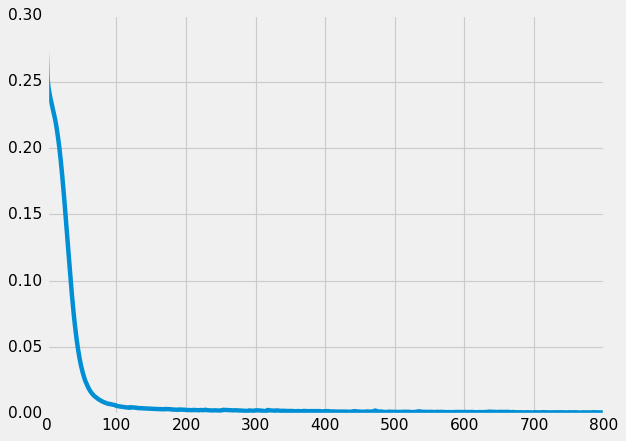

In [1806]:
for e in range(20):
    data, metadata = gen_data(shape)
    data = np.array(data)/255
    history = model.fit(data, data, epochs=10, verbose=2)
    full_history.extend(history.history['loss'])

show(full_history, plot_func='plot', axis='on')

<AxesSubplot:>

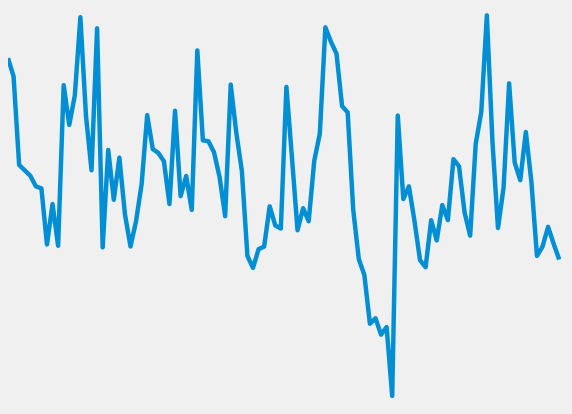

In [1807]:
show(full_history[-100:], plot_func='plot')

[['min', 0.4381934], ['max', 0.9998888], ['mean', 0.97728777]]


<module 'matplotlib.markers' from 'c:\\users\\diamo\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\matplotlib\\markers.py'>

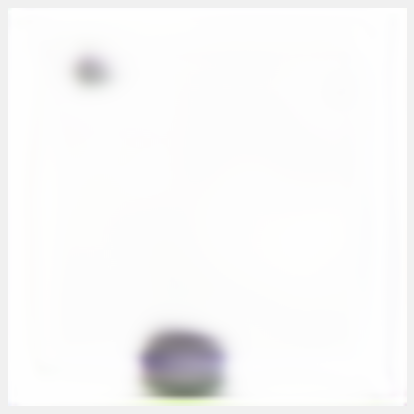

In [1812]:
i = np.random.randint(0,data.shape[0])
sample = model(data[i:i+1])[0]
print([[a, getattr(sample.numpy(), a)()] for a in ['min', 'max', 'mean']])
show(sample)
# show(data[i])
# plt.scatter(marker=)
matplotlib.markers

In [ ]:
{3:5}.values()

In [1813]:
ex = encoder(data[:1])
print(ex)
sliders = [widgets.FloatSlider(min=0, max=1, step=0.01, value=np.random.normal(ex.numpy().mean(),0.1)) for p in range(7)]
inputs = {str(a): b for a, b in enumerate(sliders)}
# print(inputs)
@interact(**inputs)
# np.random.normal(0, 1, [10])
def decode(*args, **kwargs):
    Z = list(kwargs.values())
    latent = np.expand_dims(np.array(Z), 0)
    show(decoder(latent)[0])

tf.Tensor(
[[0.7475504  0.43480188 0.6914319  0.41626555 0.47183314 0.889659
  0.12553328]], shape=(1, 7), dtype=float32)


interactive(children=(FloatSlider(value=0.46504431325540063, description='0', max=1.0, step=0.01), FloatSlider…

In [1574]:
# [f'${c["c"]}$' for c in metadata]

In [1579]:
# chr(0)
chr(3227)

'ಛ'

In [1660]:
# 
embeddings = np.array([encoder(data[i:i+1])[0] for i in range(0, data.shape[0])])

Displaying latent space embeddings for variables 5 (x) and 2 (y)


<AxesSubplot:>

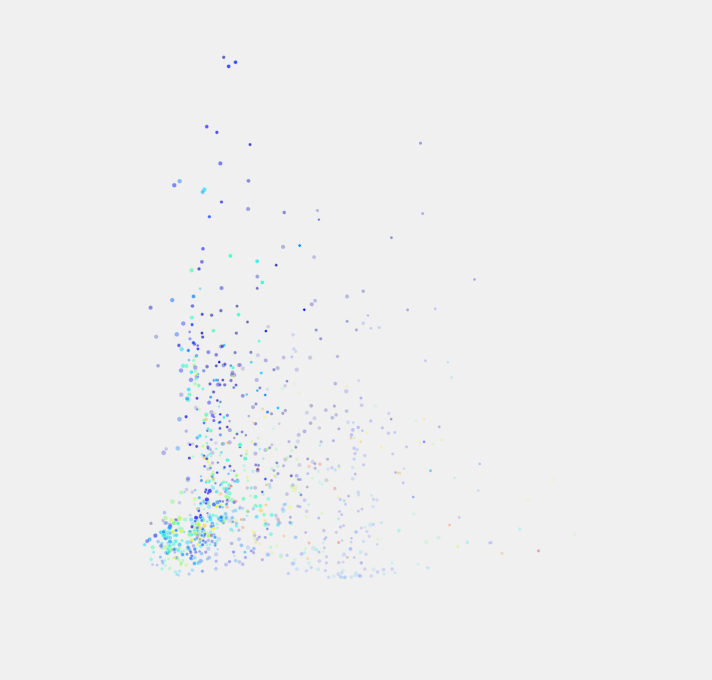

In [1674]:
# ind = np.random.randint(0,embeddings.T.shape[0]-2)
# np.random_sample()
ind = np.random.choice(np.arange(embeddings.T.shape[0]), [5], replace=False)
print(f'Displaying latent space embeddings for variables {ind[0]+1} (x) and {ind[1]+1} (y)')
# print(f'Displaying latent space embeddings for variables '+)
et = embeddings.T
def rescale(a, n, m):
    return np.interp(a, (a.min(), a.max()), (n, m))
show(
    plot_func='scatter',
    data=et[ind[:2]],
    c=et[ind[2]],
    s=rescale(et[ind[3]], 5, 20),
#     marker=[f'${c["c"]}$' for c in metadata],
    alpha=rescale(et[ind[4]], 0.1, 1),
    figure={'figsize':[10,10]}
)
# plt.scatter()
# matplotlib.collections.Collection

In [1287]:
et.T[ind[:2]].shape

(2, 7)

In [1134]:
embeddings.shape

(300, 1, 7)

In [618]:
data.shape[0]

300

In [378]:
((sample-data[i])**2).numpy().mean()

0.0029994992

<AxesSubplot:>

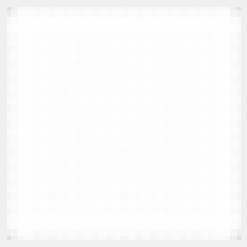

In [342]:
show(model(data[:1])[0])

In [201]:
model(data[:1])[0].shape
# convolutional neural network art

TensorShape([65, 65, 4])